In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML

from frb_common import common_utils

%matplotlib inline

No module named '_version'
Using hard-coded default config. Run update_from_site_config() toget config from kotekan


In [2]:
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.size'] = 14

In [3]:
def gauss_2d(xy, *p):
    """2D gaussian."""
    x, y = xy
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = p

    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    z = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))

    return z.ravel()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


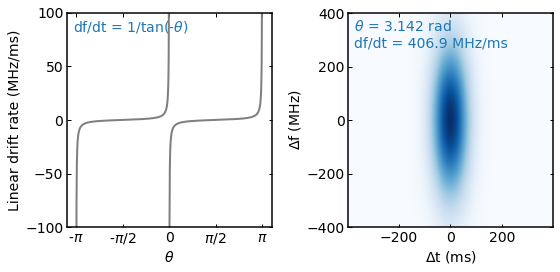

In [8]:
# amp, x0, y0, sigma_x, sigma_y, theta, offset
p0 = [10.0, 0.0, 0.0, 200, 50, 0.0, 0]

sub_factor = 64
dim = (16384 / sub_factor * 2 + 1, 400 * 2 + 1)

dts = np.arange(-dim[1] / 2 + 1, dim[1] / 2 + 1) * \
    common_utils.sampling_time_ms
dfs = np.arange(-dim[0] / 2 + 1, dim[0] / 2 + 1) * \
    common_utils.channel_bandwidth_mhz * sub_factor
    
x, y = [arr.T for arr in np.meshgrid(dfs, dts)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

xplot = np.linspace(-np.pi, np.pi, 1000)
drift_rates = 1. / np.tan(-xplot)
drift_rates[drift_rates > 400. / common_utils.sampling_time_ms] = \
    400. / common_utils.sampling_time_ms
drift_rates[drift_rates < -400. / common_utils.sampling_time_ms] = \
    -400. / common_utils.sampling_time_ms

ax1.plot(xplot[:len(xplot)//2], drift_rates[:len(xplot)//2], lw=2, color="tab:gray")
ax1.plot(xplot[len(xplot)//2:], drift_rates[len(xplot)//2:], lw=2, color="tab:gray")

line1, = ax1.plot([], [], "ko", markersize=10, color="tab:blue")

ax1.set_xticks([-np.pi, -np.pi / 2., 0, np.pi / 2., np.pi,])
ax1.set_xticklabels([r"-$\pi$", r"-$\pi$/2", "0", r"$\pi$/2", r"$\pi$"])

ax1.set_ylim(-100., 100.)

ax1.set_xlabel(r"$\theta$")
ax1.set_ylabel("Linear drift rate (MHz/ms)")

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()

xtext = 0.03 * (xlim[1] - xlim[0]) + xlim[0]
ytext = 0.97 * (ylim[1] - ylim[0]) + ylim[0]

ax1.text(xtext, ytext, r"df/dt = 1/tan(-$\theta$)",
         ha="left", va="top", color="tab:blue")

model = gauss_2d((x, y), *p0).reshape(x.shape)
im1 = ax2.imshow(model, aspect="auto", interpolation="nearest",
                 origin="lower", cmap="Blues",
                 extent=(min(dts)-np.diff(dts)[0],
                         max(dts)+np.diff(dts)[0],
                         min(dfs)-np.diff(dfs)[0],
                         max(dfs)+np.diff(dfs)[0]))

ax2.set_xlabel("$\Delta$t (ms)")
ax2.set_ylabel("$\Delta$f (MHz)")

ax2.set_xlim(min(dts)-np.diff(dts)[0], max(dts)+np.diff(dts)[0])
ax2.set_ylim(min(dfs)-np.diff(dfs)[0], max(dfs)+np.diff(dfs)[0])

xlim = ax2.get_xlim()
ylim = ax2.get_ylim()

xtext = 0.03 * (xlim[1] - xlim[0]) + xlim[0]
ytext = 0.97 * (ylim[1] - ylim[0]) + ylim[0]

text1 = ax2.text(xtext, ytext, "df/dt = {:.1f} MHz/ms".format(1. / np.tan(-p0[-2])),
                 ha="left", va="top", color="tab:blue")

plots = [line1, im1, text1]

def data_gen():
    thetas = np.linspace(-np.pi, np.pi, 101)
    i = 0
    while i < 100:
        i += 1
        theta = thetas[i]
        p0[-2] = theta
        model = gauss_2d((x, y), *p0).reshape(x.shape)
        drift_rate = 1. / np.tan(-p0[-2])
        if drift_rate > 400. / common_utils.sampling_time_ms:
            drift_rate = 400. / common_utils.sampling_time_ms
        elif drift_rate < -400. / common_utils.sampling_time_ms:
            drift_rate = -400. / common_utils.sampling_time_ms
        yield theta, drift_rate, model      

def animate(data):
    # update the data
    theta, drift_rate, model = data
    
    plots[0].set_data(theta, drift_rate)
    plots[1].set_data(model)
    plots[2].set_text(r"$\theta$ = " + \
                      "{:.3f} rad\ndf/dt = {:.1f} MHz/ms".format(
                          theta, drift_rate))
    
    return plots

plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, data_gen,
                               blit=True, interval=100,
                               repeat=True)
                                         
HTML(anim.to_html5_video())

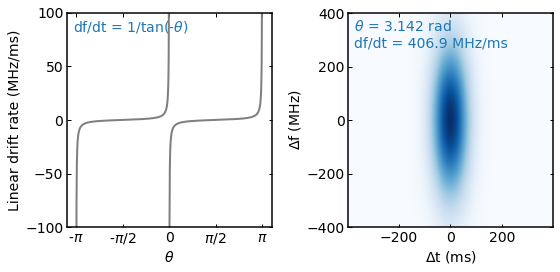

In [6]:
fig